In [32]:
#定义神经网络必备的函数
import numpy as np

def ReLU(x):
    return np.maximum(0,x)

def sigmoid(x):
    return 1/(1+np.exp(-x))

def softmax(x):
    return x/np.sum(x)

def cross_entropy_error(y,t):
    delta=1e-4
    return -np.sum(t*np.log(y+delta)) #np.log就是ln

def _numerical_gradient_no_batch(f, x): #求微分的全过程
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x) #初始化，生成和x形状相同的0数组
    
    for idx in range(x.size):
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + h
        fxh1 = f(x) # f(x+h)
        
        x[idx] = tmp_val - h 
        fxh2 = f(x) # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)
        
        x[idx] = tmp_val # 还原值
        
    return grad
'''
Attention! _numerical_gradient_no_batch(f,x)只能用于一维数组,理由如下
X=np.array([[9,8,7],[6,5,4]])
y=np.array([1,2,3])
X[1] #array([6,5,4])
y[1] #2
'''
def numerical_gradient(f, X): #求偏导数,即梯度
    if X.ndim == 1:
        return _numerical_gradient_no_batch(f, X)
    else:
        grad = np.zeros_like(X)
        
        for idx, x in enumerate(X): #enumerate实例见enumerate_example.py
            #enumerate的作用是给x标序号，存在idx中，默认从0开始
            grad[idx] = _numerical_gradient_no_batch(f, x)
            #grad得先定义成一个与X同大小的零矩阵
        return grad

def gradient_descent(f, init_x, lr=0.1, step_num=100): #梯度下降
    x=init_x
    for i in range(step_num):
        grad = numerical_gradient(f,x)
        x -= grad*lr
    
    return x

In [33]:
#简单地构建一个神经网络
class simpleNet:
    def __init__(self):
        self.W = np.random.randn(2,3) #正态分布初始化
        
    def predict(self, x):
        a1 = np.dot(x, self.W)
        z1 = sigmoid(a1)
        y = softmax(z1)
        
        return y
    
    def loss(self, x, t):
        y = self.predict(x)
        
        return cross_entropy_error(y,t)

    
#简单应用
net = simpleNet()
print('W:')
print(net.W)
x = np.array([0.6,0.9])
p = net.predict(x)
print('p:')
print(p)
label = np.argmax(p)
print('maximum index:')
print(label)
t = np.array([1,0,0])
loss = net.loss(x, t)
print('loss:')
print(loss)

W:
[[-0.5488577   1.42385074 -0.64955049]
 [ 1.1386192  -0.58190248 -0.19177872]]
p:
[0.41385821 0.36096311 0.22517869]
maximum index:
0
loss:
0.8819902551103512


# 构造一个完整的两层神经网络

In [37]:
class Two_layer_Net:
    def __init__(self, input_size, hidden_size, output_size, weight_init_std = 0.01):
        self.param = {}
        self.param['W1'] = np.random.randn(input_size, hidden_size) * weight_init_std
        self.param['b1'] = np.zeros_like(hidden_size)
        self.param['W2'] = np.random.randn(hidden_size, output_size) * weight_init_std
        self.param['b2'] = np.zeros_like(output_size)
        
    def predict(self, x):
        W1, W2 = self.param['W1'], self.param['W2']
        b1, b2 = self.param['b1'], self.param['b2']
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        return y
    
    def loss(self, x, t):
        y = self.predict(x)
        
        return cross_entropy_error(y,t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        ay = np.argmax(y, axis=1)
        at = np.argmax(t, axis=1)
        accuracy = np.sum(ay==at)/float(x.shape[0])
        
        return accuracy
    
    def numerical_gradient(self, x, t): #目标函数就是损失函数
        loss_W = lambda W:self.loss(x, t)
        
        grad = {}
        grad['W1'] = numerical_gradient(loss_W, self.param['W1'])
        grad['b1'] = numerical_gradient(loss_W, self.param['b1'])
        grad['W2'] = numerical_gradient(loss_W, self.param['W2'])
        grad['b2'] = numerical_gradient(loss_W, self.param['b2'])
        
        return grad
''''
    def gradient_descent(self, x, t, lr, step_num):
        grad = self.numerical_gradient(x, t)
        for i in range(step_num):
            for key in ('W1','b1','W2','b2'):
                self.param[key] -= lr*grad[key]
        return param
''''

## mini-batch

### 1.普通梯度下降（有问题，得改）

In [ ]:
import sys, os
sys.path.append(os.pardir)  # 为了导入父目录的文件而进行的设定
from dataset.mnist import load_mnist
# 读入数据
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)
network = Two_layer_Net(input_size=784, hidden_size=50, output_size=10)

iter_num = 1000
batch_size = 100
lr = 0.1
Total_num = x_train.shape[0]

train_loss_list = []
for i in range(iter_num):
    batch_chosen = np.random.choice(Total_num, batch_size, replace=False) #replace=False表示不放回
    x_batch = x_train[batch_chosen]
    t_batch = t_train[batch_chosen]
    
    #y = network.predict(x_batch)
    
    grad = network.numerical_gradient(x_batch, t_batch)
    for i in ('W1', 'b1', 'W2', 'b2'):
        network.param[i] -= lr*grad[i]
    
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
train_loss_list

### 2.用反向误差传播法的梯度下降

In [39]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 为了导入父目录的文件而进行的设定
import numpy as np
from common.layers import *
from common.gradient import numerical_gradient
from collections import OrderedDict


class TwoLayerNet:

    def __init__(self, input_size, hidden_size, output_size, weight_init_std = 0.01):
        # 初始化权重
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size) 
        self.params['b2'] = np.zeros(output_size)

        # 生成层
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])

        self.lastLayer = SoftmaxWithLoss()
        
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        
        return x
        
    # x:输入数据, t:监督数据
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
        
    # x:输入数据, t:监督数据
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads
        
    def gradient(self, x, t):
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.lastLayer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 设定
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W2'], grads['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads

../common/functions.py:59: RuntimeWarning: divide by zero encountered in true_divide
  -np.sum(np.log(np.array(y) + 1e-7)) / y_size


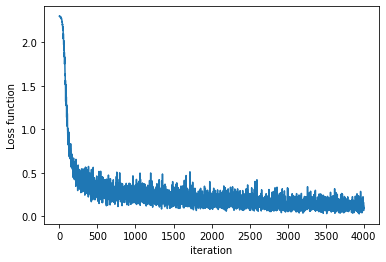

'\n# 绘制图形\nmarkers = {\'train\': \'o\', \'test\': \'s\'}\nx = np.arange(len(train_acc_list))\nplt.plot(x, train_acc_list, label=\'train acc\')\nplt.plot(x, test_acc_list, label=\'test acc\', linestyle=\'--\')\nplt.xlabel("epochs")\nplt.ylabel("accuracy")\nplt.ylim(0, 1.0)\nplt.legend(loc=\'lower right\')\nplt.show()\n'

In [41]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 为了导入父目录的文件而进行的设定
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist

# 读入数据
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

iters_num = 4000  # 适当设定循环的次数
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []

for i in range(iters_num):
    #获取mini-batch
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 计算梯度
    #grad = network.numerical_gradient(x_batch, t_batch) #这个用的是梯度法
    grad = network.gradient(x_batch, t_batch) #这个用的是误差反向传播法
    
    # 更新参数
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key] #迭代，变化参数数值
    
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)

#绘制损失函数随着迭代次数的变化图
plt.plot(range(1,iters_num+1),train_loss_list)
plt.xlabel('iteration')
plt.ylabel('Loss function')
plt.show()